In [1]:
#Every important library we are gonna use (or not but is usefull to have as a resource)
import requests
import time
import datetime
import json
import websocket

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf 
from scipy.stats import shapiro, normaltest
from datetime import timedelta, date
from collections import defaultdict
from statsmodels.tsa.stattools import adfuller

##### Fetching data and cleaning

In [2]:
def fetch_spot_data_binance(symbol, interval, startTimes, limit):
    url = 'https://data-api.binance.vision/api/v3/klines'
    
    asset_data_binance = {
        'Time' : [],
        'Open' : [],
    } 
    
    for startTime in startTimes:
        params = {
            'symbol' : symbol,
            'interval' : interval,
            'startTime' : startTime,
            'limit' : limit
        }
    
        response = requests.get(url, params)
        partial_data = response.json()
    
        for entry in partial_data:
             asset_data_binance['Time'].append(float(entry[0]))
             asset_data_binance['Open'].append(float(entry[1]))

    return asset_data_binance

def fetch_spot_data_bitget(symbol, granularity, endTimes, limit):
    url = 'https://api.bitget.com/api/v2/spot/market/history-candles'

    asset_data_bitget = {
        'Time' : [],
        'Open' : []
    }
    
    pause_timer = 0    
    for endTime in endTimes:
        params = {
                'symbol' : symbol,
                'granularity' : granularity,
                'endTime' : endTime,
                'limit' : limit
            }
        pause_timer += 1
        if pause_timer == 18:
            time.sleep(0.5)
            pause_timer = 0
            
        response = requests.get(url, params)
        if response.status_code == 200:
            pre_partial_data = response.json()
            if 'data' in pre_partial_data:
                partial_data = pre_partial_data['data']
                for entry in partial_data:
                    asset_data_bitget['Time'].append(float(entry[0]))
                    asset_data_bitget['Open'].append(float(entry[1]))

    return asset_data_bitget

def fetch_options_data():
    url = 'https://history.deribit.com/api/v2/public/get_instruments'
    params = {
        'currency' : 'BTC',
        'kind' : 'option',
        'expired' : 'true'
    }
    
    response = requests.get(url, params)
    options_data = response.json()

    return options_data.get('result',[])

def trades_per_instrument(instruments_name, start_timestamp, end_timestamp):
    instruments_url = 'https://history.deribit.com/api/v2/public/get_last_trades_by_instrument_and_time'

    instruments_trade = {instrument_name : [] for instrument_name in instruments_name}
    
    for instrument_name in instruments_name:
        params = {
            'instrument_name': instrument_name,
            'start_timestamp': start_timestamp,
            'end_timestamp': end_timestamp,
            'count': 25,  # Adjust as needed
            'sorting': 'asc'
        }
    
        response = requests.get(instruments_url, params=params)
        data = response.json()
        trades = data.get('result', {}).get('trades', [])

        for trade in trades:
            instruments_trade['instrument_name'].append(trade)        

In [3]:
#Params needed for fetching the spot data.
endTime_0 = int(datetime.datetime(2024, 11, 1).timestamp() * 1000)
start_date = int(datetime.datetime(2018, 8, 18).timestamp() * 1000)

n_hours_to_get = int((endTime_0 - start_date) / (1000 * 60 * 60))

symbol = 'BTCUSDT'
interval = granularity = '1h'
startTimes = [start_date]
endTimes = [endTime_0] #At the end, this list has to have 270+ values, because there are 263 intervals of 200 hours between start_date and endTime_0 (at least)
limit_binance = 1000
limit_bitget = 200

n_requests_binance = int(n_hours_to_get / limit_binance)
n_requests_bitget = int(n_hours_to_get / limit_bitget)
time_interval_binance = 60*60 * 1000 * limit_binance
time_interval_bitget = 60*60 * 1000 * limit_bitget

interval_to_ms = {
    '1h': 60 * 60 * 1000,
    '4h': 4 * 60 * 60 * 1000,
    '6h': 6 * 60 * 60 * 1000,
    '12h': 12 * 60 * 60 * 1000,
    '1d': 24 * 60 * 60 * 1000,
}

asset_data = {}

for i in range(n_requests_binance):
    startTimes.append(startTimes[-1] + time_interval_binance)
for i in range(n_requests_bitget):
    endTimes.insert(0, endTimes[0] - time_interval_bitget)
    

asset_data_binance = fetch_spot_data_binance(symbol, interval, startTimes, limit_binance)
asset_data_bitget = fetch_spot_data_bitget(symbol, granularity, endTimes, limit_bitget)

initial_df_binance = pd.DataFrame(asset_data_binance)
initial_df_bitget = pd.DataFrame(asset_data_bitget)

initial_df_binance['Date'] = pd.to_datetime(initial_df_binance['Time'], unit = 'ms')
initial_df_binance.set_index('Date', inplace = True)
initial_df_binance = initial_df_binance.sort_index()

initial_df_bitget['Date'] = pd.to_datetime(initial_df_bitget['Time'], unit = 'ms')
initial_df_bitget.set_index('Date', inplace = True)
initial_df_bitget = initial_df_bitget.sort_index()

In [4]:
initial_df = pd.concat([initial_df_binance,initial_df_bitget])
initial_df = initial_df.sort_index()
initial_df = initial_df.drop_duplicates(subset = 'Time')

diff = initial_df['Time'].diff().iloc[1]  
missing = (initial_df['Time'].diff() != diff).sum() - 1 
#If missing = 0, there is no data missing, if missing != 0, there is at least one hour of data missing, probably more.

##### Data transformation and statistical analysis

In [5]:
initial_df = initial_df.iloc[9:]
#The initial_df starts at 23:00, I want it to start at 08:00.
df_1h = initial_df.copy()
df_4h = initial_df.resample('4h', origin = 'start').first().copy()
df_6h = initial_df.resample('6h', origin = 'start').first().copy()
df_12h = initial_df.resample('12h', origin = 'start').first().copy()
df_1d = initial_df.resample('1D', origin = 'start').first().copy()

df_1h['returns'] = df_1h['Open'].pct_change()
df_4h['returns'] = df_4h['Open'].pct_change()
df_6h['returns'] = df_6h['Open'].pct_change()
df_12h['returns'] = df_12h['Open'].pct_change()
df_1d['returns'] = df_1d['Open'].pct_change()

window_1h = [24, 48, 72, 96, 120]
window_4h = [24, 30, 36, 42, 48]
window_6h = [16, 20, 24, 26, 30]
window_12h = [14, 28, 42, 56, 70]
window_1d = [7, 14, 30, 60, 90]

for window in window_1h:
    df_1h[f'Volatility_{window}'] = df_1h['returns'].rolling(window=window).std()
    df_1h[f'Log_Volatility_{window}'] = np.log(df_1h[f'Volatility_{window}'])
for window in window_4h:
    df_4h[f'Volatility_{window}'] = df_4h['returns'].rolling(window=window).std()
    df_4h[f'Log_Volatility_{window}'] = np.log(df_4h[f'Volatility_{window}'])
for window in window_6h:
    df_6h[f'Volatility_{window}'] = df_6h['returns'].rolling(window=window).std()
    df_6h[f'Log_Volatility_{window}'] = np.log(df_6h[f'Volatility_{window}'])
for window in window_12h:
    df_12h[f'Volatility_{window}'] = df_12h['returns'].rolling(window=window).std()
    df_12h[f'Log_Volatility_{window}'] = np.log(df_12h[f'Volatility_{window}'])
for window in window_1d:
    df_1d[f'Volatility_{window}'] = df_1d['returns'].rolling(window=window).std()
    df_1d[f'Log_Volatility_{window}'] = np.log(df_1d[f'Volatility_{window}'])

df_1h = df_1h.dropna()
df_4h = df_4h.dropna()
df_6h = df_6h.dropna()
df_12h = df_12h.dropna()
df_1d = df_1d.dropna()

In [6]:
result_1h = adfuller(df_1h['Volatility'].dropna())
print(f'ADF Statistic for 1 hour volatility: {result_1h[0]}')
print(f'p-value for 1 hour volatility: {result_1h[1]}')

result_4h = adfuller(df_4h['Volatility'].dropna())
print(f'ADF Statistic for 4 hour volatility: {result_4h[0]}')
print(f'p-value for 4 hour volatility: {result_4h[1]}')

result_6h = adfuller(df_6h['Volatility'].dropna())
print(f'ADF Statistic for 6 hour volatility: {result_6h[0]}')
print(f'p-value for 6 hour volatility: {result_6h[1]}')

result_12h = adfuller(df_12h['Volatility'].dropna())
print(f'ADF Statistic for 12 hour volatility: {result_12h[0]}')
print(f'p-value for 12 hour volatility: {result_12h[1]}')

result_1d = adfuller(df_1d['Volatility'].dropna())
print(f'ADF Statistic for 1 day volatility: {result_1d[0]}')
print(f'p-value for 1 day volatility: {result_1d[1]}')

ADF Statistic for 1 hour volatility: -13.350789769852403
p-value for 1 hour volatility: 5.674064480219799e-25
ADF Statistic for 4 hour volatility: -10.627769161242819
p-value for 4 hour volatility: 5.310260176402004e-19
ADF Statistic for 6 hour volatility: -9.143481138481112
p-value for 6 hour volatility: 2.8083016242856774e-15
ADF Statistic for 12 hour volatility: -6.893550062923463
p-value for 12 hour volatility: 1.336606861530933e-09
ADF Statistic for 1 day volatility: -6.826935143888299
p-value for 1 day volatility: 1.9371339547420097e-09


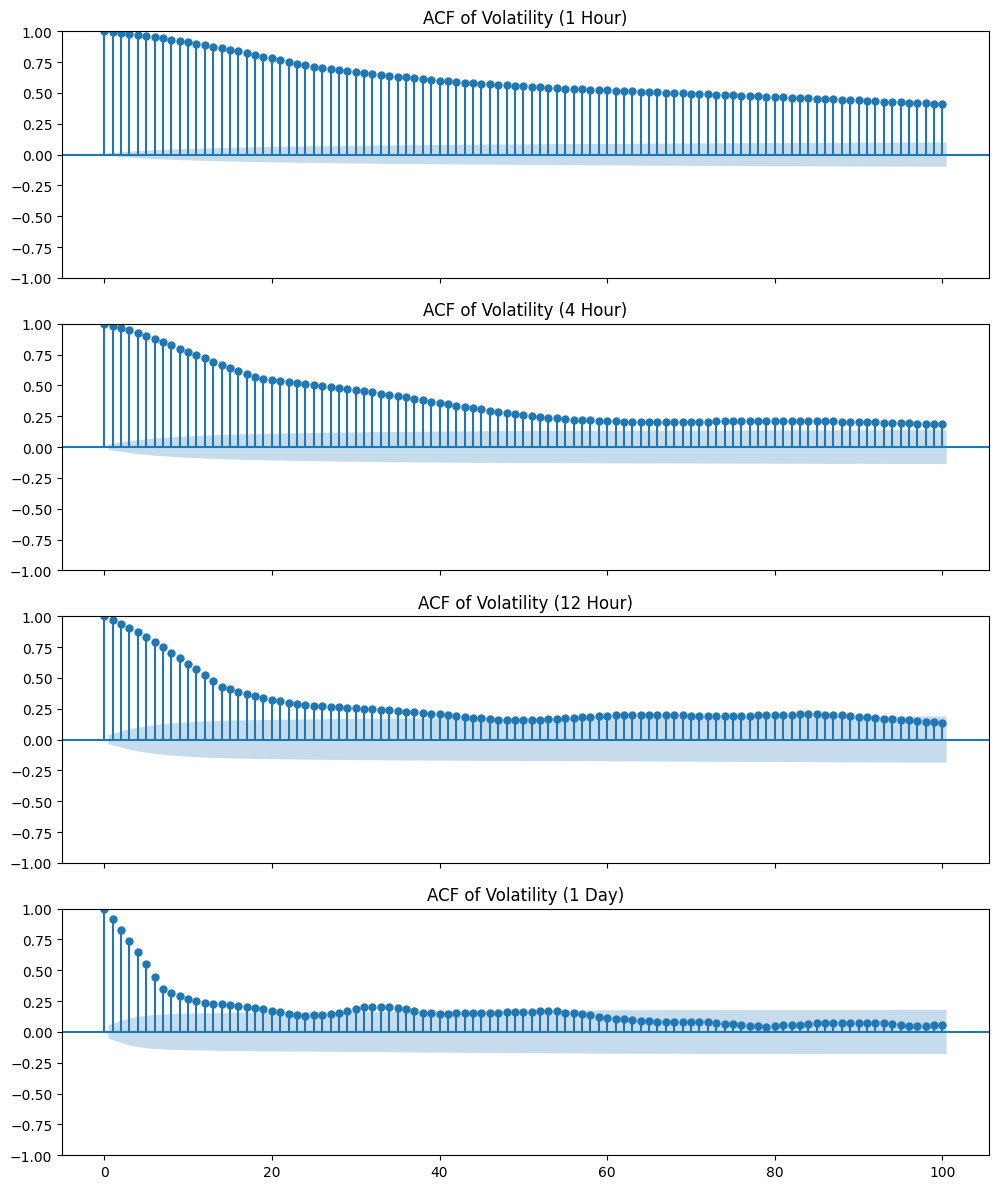

In [16]:
dataframes = [df_1h, df_4h, df_12h, df_1d]
titles = ["1 Hour", "4 Hour", "12 Hour", "1 Day"]

fig, axes = plt.subplots(nrows=len(dataframes), ncols=1, figsize=(10, 12), sharex=True)

for i, df in enumerate(dataframes):
    plot_acf(df['Volatility'], lags=100, alpha=0.01, ax=axes[i])
    axes[i].set_title(f"ACF of Volatility ({titles[i]})")

plt.tight_layout()
plt.show()

In [8]:
df_1h['Datetime'] = pd.to_datetime(df_1h['Time'], unit = 'ms')
df_4h['Datetime'] = pd.to_datetime(df_4h['Time'], unit = 'ms')

df_1h['Open_48h'] = np.nan
df_1h['Open_72h'] = np.nan
df_4h['Open_72h'] = np.nan
df_4h['Open_96h'] = np.nan
for i in range(len(df_1h)):
    current_time = df_1h.iloc[i]['Datetime']
    current_hour = current_time.hour
    
    if current_hour < 8:
        n_rows_to_shift = 48 + (8 - current_hour)
    elif current_hour > 8 and current_hour <= 19:
        n_rows_to_shift = 48 - (current_hour - 8)
    elif current_hour >= 20:
        n_rows_to_shift = 48 + 8 + 24 - current_hour
    else:
        n_rows_to_shift = 48 
    
    target_index = i + n_rows_to_shift
    if target_index < len(df_1h):
        df_1h.loc[df_1h.index[i], 'Open_48h'] = df_1h.iloc[target_index]['Open']

for i in range(len(df_1h)):
    current_time = df_1h.iloc[i]['Datetime']
    current_hour = current_time.hour
    
    if current_hour < 8:
        n_rows_to_shift = 72+ (8 - current_hour)
    elif current_hour > 8 and current_hour <= 19:
        n_rows_to_shift = 72 - (current_hour - 8)
    elif current_hour >= 20:
        n_rows_to_shift = 72 + 8 + 24 - current_hour
    else:
        n_rows_to_shift = 72 
    
    target_index = i + n_rows_to_shift
    if target_index < len(df_1h):
        df_1h.loc[df_1h.index[i], 'Open_72h'] = df_1h.iloc[target_index]['Open']

for i in range(len(df_4h)):
    current_time = df_4h.iloc[i]['Datetime']
    current_hour = current_time.hour
    
    if current_hour < 8:
        n_rows_to_shift = int((72+ (8 - current_hour))/4)
    elif current_hour > 8 and current_hour <= 19:
        n_rows_to_shift = int((72 - (current_hour - 8))/4)
    elif current_hour >= 20:
        n_rows_to_shift = int((72 + 8 + 24 - current_hour)/4)
    else:
        n_rows_to_shift = int(72 /4)
    
    target_index = i + n_rows_to_shift
    if target_index < len(df_4h):
        df_4h.loc[df_4h.index[i], 'Open_72h'] = df_4h.iloc[target_index]['Open']

for i in range(len(df_4h)):
    current_time = df_4h.iloc[i]['Datetime']
    current_hour = current_time.hour
    
    if current_hour < 8:
        n_rows_to_shift = int((96+ (8 - current_hour))/4)
    elif current_hour > 8 and current_hour <= 19:
        n_rows_to_shift = int((96 - (current_hour - 8))/4)
    elif current_hour >= 20:
        n_rows_to_shift = int((96 + 8 + 24 - current_hour)/4)
    else:
        n_rows_to_shift = int(96 /4)
    
    target_index = i + n_rows_to_shift
    if target_index < len(df_4h):
        df_4h.loc[df_4h.index[i], 'Open_96h'] = df_4h.iloc[target_index]['Open']

static_percentile_20_1h = np.percentile(df_1h['Volatility'], 20)
static_percentile_20_4h = np.percentile(df_4h['Volatility'], 20)
static_percentile_20_6h = np.percentile(df_6h['Volatility'], 20)
static_percentile_20_12h = np.percentile(df_12h['Volatility'], 20)
static_percentile_20_1d = np.percentile(df_1d['Volatility'], 20)

static_percentile_80_1h = np.percentile(df_1h['Volatility'], 80)
static_percentile_80_4h = np.percentile(df_4h['Volatility'], 80)
static_percentile_80_6h = np.percentile(df_6h['Volatility'], 80)
static_percentile_80_12h = np.percentile(df_12h['Volatility'], 80)
static_percentile_80_1d = np.percentile(df_1d['Volatility'], 80)

df_1h['Move_1'] = ((df_1h['Open_48h'] / df_1h['Open']) - 1) *100
df_1h['Move_2'] = ((df_1h['Open_72h'] / df_1h['Open']) - 1) *100
df_1h.loc[:, '20th_percent'] = (df_1h['Volatility'] < static_percentile_20_1h).astype(int)
df_1h.loc[:, '80th_percent'] = (df_1h['Volatility'] > static_percentile_80_1h).astype(int)

df_4h['Move_1'] = ((df_4h['Open_72h'] / df_4h['Open']) - 1) *100
df_4h['Move_2'] = ((df_4h['Open_96h'] / df_4h['Open']) - 1) *100
df_4h.loc[:, '20th_percent'] = (df_4h['Volatility'] < static_percentile_20_4h).astype(int)
df_4h.loc[:, '80th_percent'] = (df_4h['Volatility'] > static_percentile_80_4h).astype(int)

df_6h['Open_96h'] = df_6h['Open'].shift(-16)
df_6h['Open_120h'] = df_6h['Open'].shift(-20)
df_6h['Date'] = pd.to_datetime(df_6h['Time'],unit='ms')
df_6h.set_index('Date', inplace = True)
df_6h['Move_1'] = ((df_6h['Open_96h'] / df_6h['Open']) - 1) *100
df_6h['Move_2'] = ((df_6h['Open_120h'] / df_6h['Open']) - 1) *100
df_6h.loc[:, '20th_percent'] = (df_6h['Volatility'] < static_percentile_20_6h).astype(int)
df_6h.loc[:, '80th_percent'] = (df_6h['Volatility'] > static_percentile_80_6h).astype(int)

df_12h['Open_5d'] = df_12h['Open'].shift(-10)
df_12h['Open_7d'] = df_12h['Open'].shift(-14)
df_12h['Date'] = pd.to_datetime(df_12h['Time'],unit='ms')
df_12h.set_index('Date', inplace = True)
df_12h['Move_1'] = ((df_12h['Open_5d'] / df_12h['Open']) - 1) *100
df_12h['Move_2'] = ((df_12h['Open_7d'] / df_12h['Open']) - 1) *100
df_12h.loc[:, '20th_percent'] = (df_12h['Volatility'] < static_percentile_20_12h).astype(int)
df_12h.loc[:, '80th_percent'] = (df_12h['Volatility'] > static_percentile_80_12h).astype(int)

df_1d['Open_7d'] = df_1d['Open'].shift(-7)
df_1d['Open_10d'] = df_1d['Open'].shift(-10)
df_1d['Open_30d'] = df_1d['Open'].shift(-30)
#df_1d['Time_30d'] = df_1d['Time'].shift(-30)
#df_1d['Time_30d'] = pd.to_datetime(df_1d['Time_30d'], unit='ms')
df_1d['Date'] = pd.to_datetime(df_1d['Time'],unit='ms')
df_1d.set_index('Date', inplace = True)
df_1d['Move_1'] = ((df_1d['Open_7d'] / df_1d['Open']) - 1) *100
df_1d['Move_2'] = ((df_1d['Open_10d'] / df_1d['Open']) - 1) *100
df_1d['Move_3'] = ((df_1d['Open_30d'] / df_1d['Open']) - 1) *100
df_1d.loc[:, '20th_percent'] = (df_1d['Volatility'] < static_percentile_20_1d).astype(int)
df_1d.loc[:, '80th_percent'] = (df_1d['Volatility'] > static_percentile_80_1d).astype(int)

In [11]:
signal_days_1h = df_1h.loc[df_1h['20th_percent'] == 1, 'Time'].unique()
signal_days_1h = sorted(signal_days_1h)
high_days_1h = df_1h.loc[df_1h['80th_percent'] == 1, 'Time'].unique()
high_days_1h = sorted(high_days_1h)

signal_days_4h = df_4h.loc[df_4h['20th_percent'] == 1, 'Time'].unique()
signal_days_4h = sorted(signal_days_4h)
high_days_4h = df_4h.loc[df_4h['80th_percent'] == 1, 'Time'].unique()
high_days_4h = sorted(high_days_4h)

signal_days_6h = df_6h.loc[df_6h['20th_percent'] == 1, 'Time'].unique()
signal_days_6h = sorted(signal_days_6h)
high_days_6h = df_6h.loc[df_6h['80th_percent'] == 1, 'Time'].unique()
high_days_6h = sorted(high_days_6h)

signal_days_12h = df_12h.loc[df_12h['20th_percent'] == 1, 'Time'].unique()
signal_days_12h = sorted(signal_days_12h)
high_days_12h = df_12h.loc[df_12h['80th_percent'] == 1, 'Time'].unique()
high_days_12h = sorted(high_days_12h)

signal_days_1d = df_1d.loc[df_1d['20th_percent'] == 1, 'Time'].unique()
signal_days_1d = sorted(signal_days_1d)
high_days_1d = df_1d.loc[df_1d['80th_percent'] == 1, 'Time'].unique()
high_days_1d = sorted(high_days_1d)

df_1h_low = df_1h[df_1h['Time'].isin(signal_days_1h)]
df_4h_low = df_4h[df_4h['Time'].isin(signal_days_4h)]
df_6h_low = df_6h[df_6h['Time'].isin(signal_days_6h)]
df_12h_low = df_12h[df_12h['Time'].isin(signal_days_12h)]
df_1d_low = df_1d[df_1d['Time'].isin(signal_days_1d)]

df_1h_high = df_1h[df_1h['Time'].isin(high_days_1h)]
df_4h_high = df_4h[df_4h['Time'].isin(high_days_4h)]
df_6h_high = df_6h[df_6h['Time'].isin(high_days_6h)]
df_12h_high = df_12h[df_12h['Time'].isin(high_days_12h)]
df_1d_high = df_1d[df_1d['Time'].isin(high_days_1d)]


signal_days_1h_72h = [i + 72*60*60 * 1000 for i in signal_days_1h]

In [12]:
mean_1h_1 = np.mean(df_1h_low['Move_1'])
mean_1h_2 = np.mean(df_1h_low['Move_2'])
std_1h_1 = df_1h_low['Move_1'].std()
std_1h_2 = df_1h_low['Move_2'].std()

mean_4h_1 = np.mean(df_4h_low['Move_1'])
mean_4h_2 = np.mean(df_4h_low['Move_2'])
std_4h_1 = df_4h_low['Move_1'].std()
std_4h_2 = df_4h_low['Move_2'].std()

mean_6h_1 = np.mean(df_6h_low['Move_1'])
mean_6h_2 = np.mean(df_6h_low['Move_2'])
std_6h_1 = df_6h_low['Move_1'].std()
std_6h_2 = df_6h_low['Move_2'].std()

mean_12h_1 = np.mean(df_12h_low['Move_1'])
mean_12h_2 = np.mean(df_12h_low['Move_2'])
std_12h_1 = df_12h_low['Move_1'].std()
std_12h_2 = df_12h_low['Move_2'].std()

mean_1d_1 = np.mean(df_1d_low['Move_1'])
mean_1d_2 = np.mean(df_1d_low['Move_2'])
mean_1d_3 = np.mean(df_1d_low['Move_3'])
std_1d_1 = df_1d_low['Move_1'].std()
std_1d_2 = df_1d_low['Move_2'].std()
std_1d_3 = df_1d_low['Move_3'].std()

print(f'Mean and standard deviation of the Move for 48h lookahead (1h low vol): {mean_1h_1} {std_1h_1}')
print(f'Mean and standard deviation of the Move for 72h lookahead (1h low vol): {mean_1h_2} {std_1h_2}')
print(f'Mean and standard deviation of the Move for 72h lookahead (4h low vol): {mean_4h_1} {std_4h_1}')
print(f'Mean and standard deviation of the Move for 96h lookahead (4h low vol): {mean_4h_2} {std_4h_2}')
print(f'Mean and standard deviation of the Move for 96h lookahead (6h low vol): {mean_6h_1} {std_6h_1}')
print(f'Mean and standard deviation of the Move for 120h lookahead (6h low vol): {mean_6h_2} {std_6h_2}')
print(f'Mean and standard deviation of the Move for 5d lookahead (12h low vol): {mean_12h_1} {std_12h_1}')
print(f'Mean and standard deviation of the Move for 7d lookahead (12h low vol): {mean_12h_2} {std_12h_2}')
print(f'Mean and standard deviation of the Move for 7d lookahead (1d low vol): {mean_1d_1} {std_1d_1}')
print(f'Mean and standard deviation of the Move for 10d lookahead (1d low vol): {mean_1d_2} {std_1d_2}')
print(f'Mean and standard deviation of the Move for 30d lookahead (1d low vol): {mean_1d_3} {std_1d_3}')

Mean and standard deviation of the Move for 48h lookahead (1h low vol): 0.2100698393142737 3.747069802178565
Mean and standard deviation of the Move for 72h lookahead (1h low vol): 0.39627331250066794 4.710899997582515
Mean and standard deviation of the Move for 72h lookahead (4h low vol): 0.5691166396073039 4.752507025742552
Mean and standard deviation of the Move for 96h lookahead (4h low vol): 0.7419682640630437 5.628064499771764
Mean and standard deviation of the Move for 96h lookahead (6h low vol): 0.9895720990081085 5.529006408838985
Mean and standard deviation of the Move for 120h lookahead (6h low vol): 1.2835997071518994 6.309945830004927
Mean and standard deviation of the Move for 5d lookahead (12h low vol): 1.1476252650433678 6.519736556926042
Mean and standard deviation of the Move for 7d lookahead (12h low vol): 1.914522335404071 8.168282754079987
Mean and standard deviation of the Move for 7d lookahead (1d low vol): 1.3280853262383678 8.628329732778676
Mean and standard d

In [13]:
mean_1h_1 = np.mean(df_1h_high['Move_1'])
mean_1h_2 = np.mean(df_1h_high['Move_2'])
std_1h_1 = df_1h_high['Move_1'].std()
std_1h_2 = df_1h_high['Move_2'].std()

mean_4h_1 = np.mean(df_4h_high['Move_1'])
mean_4h_2 = np.mean(df_4h_high['Move_2'])
std_4h_1 = df_4h_high['Move_1'].std()
std_4h_2 = df_4h_high['Move_2'].std()

mean_6h_1 = np.mean(df_6h_high['Move_1'])
mean_6h_2 = np.mean(df_6h_high['Move_2'])
std_6h_1 = df_6h_high['Move_1'].std()
std_6h_2 = df_6h_high['Move_2'].std()

mean_12h_1 = np.mean(df_12h_high['Move_1'])
mean_12h_2 = np.mean(df_12h_high['Move_2'])
std_12h_1 = df_12h_high['Move_1'].std()
std_12h_2 = df_12h_high['Move_2'].std()

mean_1d_1 = np.mean(df_1d_high['Move_1'])
mean_1d_2 = np.mean(df_1d_high['Move_2'])
mean_1d_3 = np.mean(df_1d_high['Move_3'])
std_1d_1 = df_1d_high['Move_1'].std()
std_1d_2 = df_1d_high['Move_2'].std()
std_1d_3 = df_1d_high['Move_3'].std()

print(f'Mean and standard deviation of the Move for 48h lookahead (1h high vol): {mean_1h_1} {std_1h_1}')
print(f'Mean and standard deviation of the Move for 72h lookahead (1h high vol): {mean_1h_2} {std_1h_2}')
print(f'Mean and standard deviation of the Move for 72h lookahead (4h high vol): {mean_4h_1} {std_4h_1}')
print(f'Mean and standard deviation of the Move for 96h lookahead (4h high vol): {mean_4h_2} {std_4h_2}')
print(f'Mean and standard deviation of the Move for 96h lookahead (6h high vol): {mean_6h_1} {std_6h_1}')
print(f'Mean and standard deviation of the Move for 120h lookahead (6h high vol): {mean_6h_2} {std_6h_2}')
print(f'Mean and standard deviation of the Move for 5d lookahead (12h high vol): {mean_12h_1} {std_12h_1}')
print(f'Mean and standard deviation of the Move for 7d lookahead (12h high vol): {mean_12h_2} {std_12h_2}')
print(f'Mean and standard deviation of the Move for 7d lookahead (1d high vol): {mean_1d_1} {std_1d_1}')
print(f'Mean and standard deviation of the Move for 10d lookahead (1d high vol): {mean_1d_2} {std_1d_2}')
print(f'Mean and standard deviation of the Move for 30d lookahead (1d high vol): {mean_1d_3} {std_1d_3}')

Mean and standard deviation of the Move for 48h lookahead (1h high vol): 0.33725794361525535 6.098070472402371
Mean and standard deviation of the Move for 72h lookahead (1h high vol): 0.531171348413693 7.236871223144414
Mean and standard deviation of the Move for 72h lookahead (4h high vol): 0.6291432372792578 7.351739786433047
Mean and standard deviation of the Move for 96h lookahead (4h high vol): 0.8346621907355756 8.394771334113996
Mean and standard deviation of the Move for 96h lookahead (6h high vol): 0.9546339070870534 8.034310624147972
Mean and standard deviation of the Move for 120h lookahead (6h high vol): 1.1061040391525343 8.864409620319938
Mean and standard deviation of the Move for 5d lookahead (12h high vol): 0.9969392812542329 8.704440941951004
Mean and standard deviation of the Move for 7d lookahead (12h high vol): 1.4956416165446693 9.991581562968593
Mean and standard deviation of the Move for 7d lookahead (1d high vol): 1.2653212460537273 10.521306116211534
Mean and 

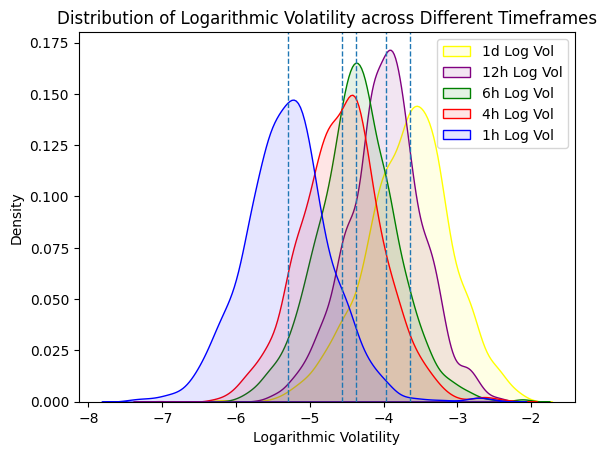

In [67]:
# Resample each DataFrame to daily mean
df_1h_resampled = df_1h.resample('D').mean()
df_4h_resampled = df_4h.resample('D').mean()
df_6h_resampled = df_6h.resample('D').mean()
df_12h_resampled = df_12h.resample('D').mean()
df_1d_resampled = df_1d.resample('D').mean()

# Create a new DataFrame combining all volatility data
all_log_volatility = pd.DataFrame({
    'Volatility': pd.concat([
        df_1h_resampled['Log_Volatility'], df_4h_resampled['Log_Volatility'],
        df_6h_resampled['Log_Volatility'], df_12h_resampled['Log_Volatility'],
        df_1d_resampled['Log_Volatility']
    ]),
    'Category': ['1h'] * len(df_1h_resampled) + ['4h'] * len(df_4h_resampled) +
                ['6h'] * len(df_6h_resampled) + ['12h'] * len(df_12h_resampled) +
                ['1d'] * len(df_1d_resampled)
})

# Plot KDE with specified order and fill
sns.kdeplot(data=all_log_volatility, x='Volatility', hue='Category', palette=['blue', 'red', 'green', 'purple', 'yellow'], fill=True, hue_order=['1h', '4h', '6h', '12h', '1d'], alpha = 0.1)

# Add vertical lines for the median of each distribution
for category in ['1h', '4h', '6h', '12h', '1d']:
    median_value = all_log_volatility[all_log_volatility['Category'] == category]['Volatility'].median()
    plt.axvline(median_value, linestyle='--', linewidth=1)

plt.title('Distribution of Logarithmic Volatility across Different Timeframes')
plt.xlabel('Logarithmic Volatility')
plt.ylabel('Density')
plt.legend(['1d Log Vol', '12h Log Vol', '6h Log Vol', '4h Log Vol', '1h Log Vol'])  # Adding legend to differentiate categories
plt.show()

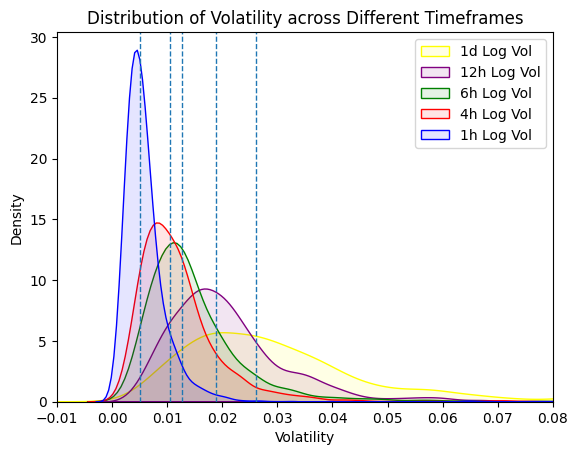

In [64]:
# Resample each DataFrame to daily mean
df_1h_resampled = df_1h.resample('D').mean()
df_4h_resampled = df_4h.resample('D').mean()
df_6h_resampled = df_6h.resample('D').mean()
df_12h_resampled = df_12h.resample('D').mean()
df_1d_resampled = df_1d.resample('D').mean()

# Create a new DataFrame combining all volatility data
all_volatility = pd.DataFrame({
    'Volatility': pd.concat([
        df_1h_resampled['Volatility'], df_4h_resampled['Volatility'],
        df_6h_resampled['Volatility'], df_12h_resampled['Volatility'],
        df_1d_resampled['Volatility']
    ]),
    'Category': ['1h'] * len(df_1h_resampled) + ['4h'] * len(df_4h_resampled) +
                ['6h'] * len(df_6h_resampled) + ['12h'] * len(df_12h_resampled) +
                ['1d'] * len(df_1d_resampled)
})

# Plot KDE with specified order and fill
sns.kdeplot(data=all_volatility, x='Volatility', hue='Category', palette=['blue', 'red', 'green', 'purple', 'yellow'], fill=True, hue_order=['1h', '4h', '6h', '12h', '1d'], alpha=0.1)

# Add vertical lines for the median of each distribution
for category in ['1h', '4h', '6h', '12h', '1d']:
    median_value = all_volatility[all_volatility['Category'] == category]['Volatility'].median()
    plt.axvline(median_value, linestyle='--', linewidth=1)

plt.title('Distribution of Volatility across Different Timeframes')
plt.xlabel('Volatility')
plt.xlim(-0.01,0.08)
plt.ylabel('Density')
plt.legend(['1d Log Vol', '12h Log Vol', '6h Log Vol', '4h Log Vol', '1h Log Vol'])  # Adding legend to differentiate categories
plt.show()

##### Fetching options data

In [ ]:
options_data = fetch_options_data()

In [ ]:
options_data[0]

In [ ]:
options_data = pd.DataFrame(options_data)
options_data.drop(columns = 
                  ['tick_size_steps','tick_size','settlement_period','settlement_currency',
                   'rfq','settlement_currency','price_index','instrument_id',
                   'creation_timestamp','counter_currency','contract_size','block_trade_tick_size',
                   'block_trade_min_trade_amount','block_trade_commission','base_currency','kind','is_active'],inplace=True) 

options_data['Date'] = (pd.to_datetime(options_data['expiration_timestamp'], unit = 'ms'))
options_data = options_data[options_data['Date'].dt.hour == 8]
options_data = options_data[options_data['option_type'] == 'call']
options_data['Date'] = options_data['Date'].dt.date
#options_data_1h.set_index('Date', inplace = True)

options_data.drop(columns = 
                  ['quote_currency', 'option_type', 'min_trade_amount'],inplace=True) 

options_data_1h = options_data[options_data['expiration_timestamp'].isin(signal_days_1h_72h)]

In [ ]:
df_1h.loc[:,'Adjusted_date'] = np.where(
    df_1h['Datetime'].dt.hour < 20,
    df_1h['Datetime'].dt.date,
    (df_1h['Datetime'] + pd.Timedelta(days=1)).dt.date
)

df_1h = df_1h[~df_1h['Adjusted_date'].duplicated()].copy()

In [ ]:
options_data_1h.head(25)

In [ ]:
df_1h.head(20)

In [ ]:
butterfly_options = {}

for i in range(len(df_1h)):
    instrument_names = []
    instrument_strikes = []
    day = df_1h.iloc[i]['Adjusted_date'] + pd.Timedelta(days=3)
    day_open = df_1h.iloc[i]['Open']

    matching_rows = options_data_1h[options_data_1h['Date'] == day]
    
    if not matching_rows.empty:
        instrument_names = matching_rows['instrument_name'].tolist()
        instrument_strikes = matching_rows['strike'].tolist()

        closest_index = min(range(len(instrument_strikes)), key=lambda x: abs(instrument_strikes[x] - day_open))
        lowest_index = min(range(len(instrument_strikes)), key=lambda x: abs(instrument_strikes[x] - day_open * 0.95))
        highest_index = min(range(len(instrument_strikes)), key=lambda x: abs(instrument_strikes[x] - day_open * 1.05))

        closest_name = instrument_names[closest_index]
        lowest_name = instrument_names[lowest_index]
        highest_name = instrument_names[highest_index]

        butterfly_options[day] = {
            'lowest' : lowest_name,
            'closest' : closest_name,
            'highest' : highest_name        
        }

In [ ]:
print(len(instrument_names), len(instrument_strikes))

In [ ]:
butterfly_options